# Ames battery prognosis

Based on article [A Data-Driven Predictive Prognostic Model for Lithium-ion Batteries based on a Deep Learning Algorithm](https://www.mdpi.com/1996-1073/12/4/660).

Dataset available at [NASA Prognostics Center of Excellence](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/).

## Data description

A set of four Li-ion batteries (# 5, 6, 7 and 18) were run through 3 different operational profiles (charge, discharge and impedance) at room temperature. 

- Charging was carried out in a constant current (CC) mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA.

- Discharge was carried out at a constant current (CC) level of 2A until the battery voltage fell to 2.7V, 2.5V, 2.2V and 2.5V for batteries 5 6 7 and 18 respectively. 

- Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz.

Repeated charge and discharge cycles result in accelerated aging of the batteries while impedance measurements provide insight into the internal battery parameters that change as aging progresses. The experiments were stopped when the batteries reached end-of-life (EOL) criteria, which was a 30% fade in rated capacity (from 2Ahr to 1.4Ahr). This dataset can be used for the prediction of both remaining charge (for a given discharge cycle) and remaining useful life (RUL).

Data Structure:

- cycle:	top level structure array containing the charge, discharge and impedance operations
	- type: 	operation  type, can be charge, discharge or impedance
	- ambient_temperature:	ambient temperature (degree C)
	- time: 	the date and time of the start of the cycle, in MATLAB  date vector format
	- data:	data structure containing the measurements

	  For charge, the fields are:
		- Voltage_measured: 	Battery terminal voltage (Volts)
		- Current_measured:	Battery output current (Amps)
		- Temperature_measured: 	Battery temperature (degree C)
		- Current_charge:		Current measured at charger (Amps)
		- Voltage_charge:		Voltage measured at charger (Volts)
		- Time:			Time vector for the cycle (secs)

	  For discharge, the fields are:
		- Voltage_measured: 	Battery terminal voltage (Volts)
		- Current_measured:	Battery output current (Amps)
		- Temperature_measured: 	Battery temperature (degree C)
		- Current_charge:		Current measured at load (Amps)
		- Voltage_charge:		Voltage measured at load (Volts)
		- Time:			Time vector for the cycle (secs)
		- Capacity:		Battery capacity (Ahr) for discharge till 2.7V 
	   
    For impedance, the fields are:
		- Sense_current:		Current in sense branch (Amps)
		- Battery_current:	Current in battery branch (Amps)
		- Current_ratio:		Ratio of the above currents 
		- Battery_impedance:	Battery impedance (Ohms) computed from raw data
		- Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms) 
		- Re:			Estimated electrolyte resistance (Ohms)
		- Rct:			Estimated charge transfer resistance (Ohms)


## Environment setup

In [1]:
import os
import zipfile
import csv
from collections import Counter
import scipy.io

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
import sklearn

print(f"scikit-learn version: {sklearn.__version__}")
assert sklearn.__version__ >= "0.20"

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

scikit-learn version: 0.22.2.post1


In [4]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

TensorFlow version: 2.3.0
Keras version: 2.4.0


## Dataset download and extraction

In [5]:
download_path = "/tmp/"
archive_file_path = download_path + "nasa_ames_battery.zip"

# Download dataset as ZIP archive on local storage
!wget --no-check-certificate https://ti.arc.nasa.gov/c/5/ -O $archive_file_path

--2020-09-24 14:51:40--  https://ti.arc.nasa.gov/c/5/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/BatteryAgingARC-FY08Q4.zip [following]
--2020-09-24 14:51:40--  https://ti.arc.nasa.gov/m/project/prognostic-repository/BatteryAgingARC-FY08Q4.zip
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 56517371 (54M) [application/zip]
Saving to: ‘/tmp/nasa_ames_battery.zip’

/tmp/nasa_ames_batt 100%[===================>]  53.90M  36.5MB/s    in 1.5s    

2020-09-24 14:51:41 (36.5 MB/s) - ‘/tmp/nasa_ames_battery.zip’ saved [56517371/56517371]



In [6]:
# Extract ZIP archive
zip_ref = zipfile.ZipFile(archive_file_path, 'r')
zip_ref.extractall(download_path)
zip_ref.close()

## Data plotting for a battery

In [7]:
def get_file_data(mat_file_name):
    """Load a MATLAB file and return its data"""

    mat_file_path = download_path + mat_file_name + ".mat"
    mat_file = scipy.io.loadmat(mat_file_path)
    print(f"File '{mat_file_path}' loaded")

    # Parse file data
    mat_data = mat_file[mat_file_name]
    return mat_data

In [8]:
# Define plotted battery number
battery_number = 5

mat_file_name = "B00" + f"{battery_number:02d}"
mat_data = get_file_data(mat_file_name)

cycles = mat_data[0][0][0][0]
cycle_count = len(cycles)
print(f"{cycle_count} cycles found")

File '/tmp/B0005.mat' loaded
616 cycles found


In [9]:
# Parse battery cycles

cycle_types = []
battery_soh = []
charging_voltages = []
discharging_voltages = []
charging_currents = []
discharging_currents = []
initial_capacity = None

for i, cycle in enumerate(cycles):
    # Cycle structure: type, ambient_temperature, time, data
    cycle_type = cycle[0][0]
    cycle_types.append(cycle_type)
    # print(f"Cycle {i+1}: {cycle_type}")
    cycle_data = cycle[3]

    if cycle_type == "charge" and i == 0:
        # Charge cycle structure: Voltage_measured, Current_measured, Temperature_measured,	Current_charge, Voltage_charge, Time
        charging_voltages = cycle_data[0][0][0][0]
        charging_currents = cycle_data[0][0][1][0]

    elif cycle_type == "discharge":
        # Discharge cycle structure: Voltage_measured, Current_measured, Temperature_measured,	Current_charge, Voltage_charge, Time, Capacity
        cycle_capacity = cycle_data[0][0][6][0][0]
        if initial_capacity == None:
            # First discharging cycle
            initial_capacity = cycle_capacity
            discharging_voltages = cycle_data[0][0][0][0]
            discharging_currents = cycle_data[0][0][1][0]
        battery_soh.append(cycle_capacity / initial_capacity)

print("Cycle types " + str(dict(Counter(cycle_types))))

Cycle types {'charge': 170, 'discharge': 168, 'impedance': 278}


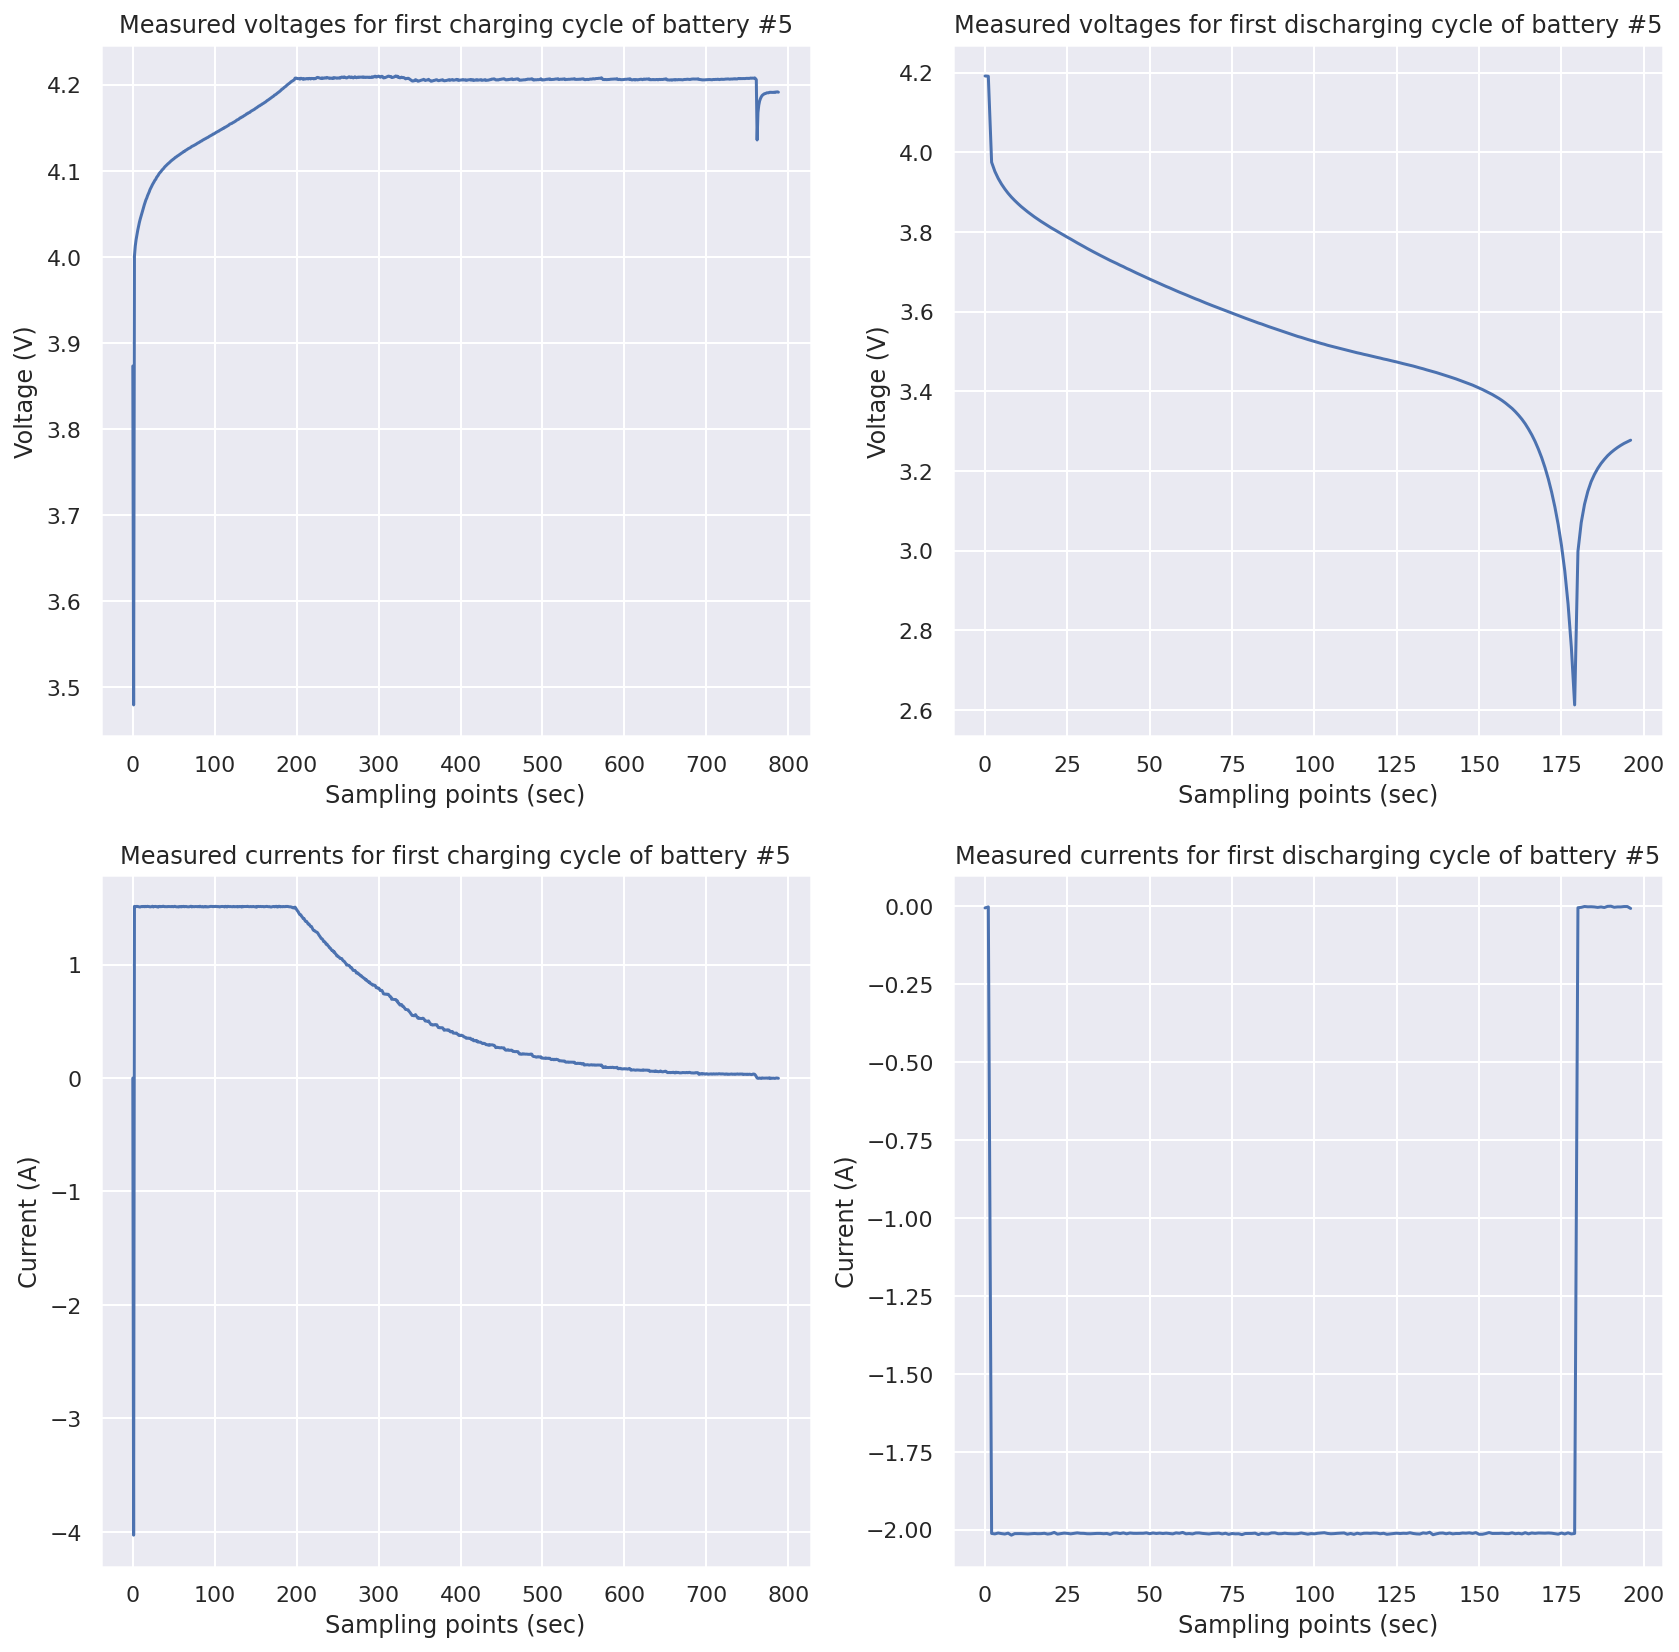

In [10]:
# Plot data for first cycle of battery
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.plot(charging_voltages)
plt.xlabel("Sampling points (sec)")
plt.ylabel("Voltage (V)")
plt.title(f"Measured voltages for first charging cycle of battery #{battery_number}")

# Plot discharging voltages
plt.subplot(2, 2, 2)
plt.plot(discharging_voltages)
plt.xlabel("Sampling points (sec)")
plt.ylabel("Voltage (V)")
plt.title(
    f"Measured voltages for first discharging cycle of battery #{battery_number}"
)

# Plot charging currents
plt.subplot(2, 2, 3)
plt.plot(charging_currents)
plt.xlabel("Sampling points (sec)")
plt.ylabel("Current (A)")
plt.title(f"Measured currents for first charging cycle of battery #{battery_number}")

# Plot discharging currents
plt.subplot(2, 2, 4)
plt.plot(discharging_currents)
plt.xlabel("Sampling points (sec)")
plt.ylabel("Current (A)")
plt.title(
    f"Measured currents for first discharging cycle of battery #{battery_number}"
)

plt.show()

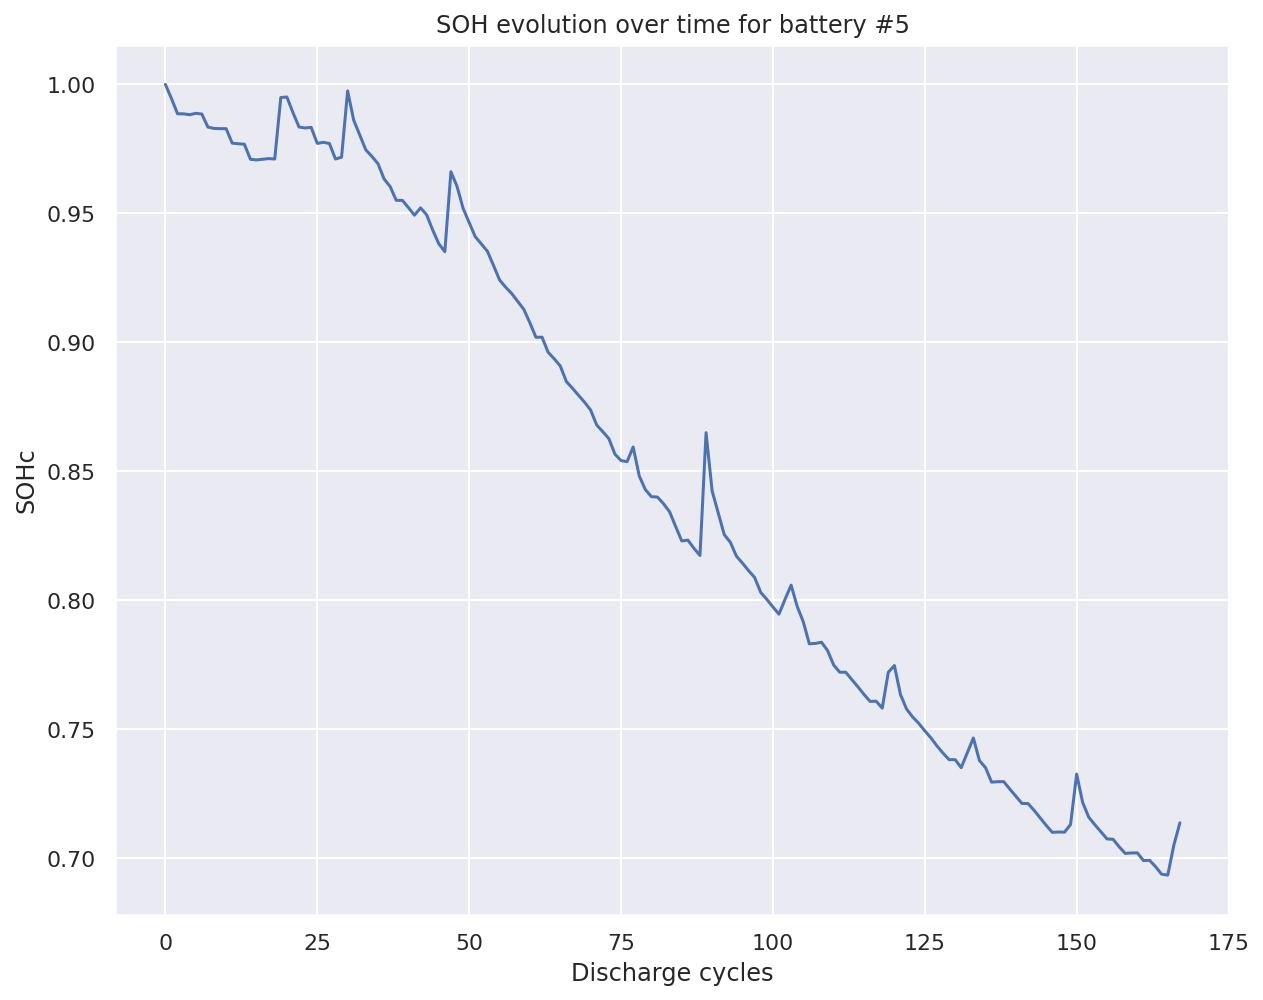

In [11]:
# Plot SOH
plt.figure()
plt.plot(battery_soh)
plt.xlabel("Discharge cycles")
plt.ylabel("SOHc")
plt.title(f"SOH evolution over time for battery #{battery_number}")
plt.show()

## Data export to CSV files

In [12]:
# Export data in CSV form for all batteries in the dataset

battery_numbers = [5, 6, 7, 18]

for battery_number in battery_numbers:
    # Load file data
    mat_file_name = "B00" + f"{battery_number:02d}"
    mat_data = get_file_data(mat_file_name)
    cycles = mat_data[0][0][0][0]

    discharging_data = []

    for cycle in cycles:
        # Cycle structure: type, ambient_temperature, time, data
        cycle_type = cycle[0][0]

        if cycle_type == "discharge":
            # Discharge cycle structure: Voltage_measured, Current_measured, Temperature_measured,	Current_charge, Voltage_charge, Time, Capacity
            cycle_data = cycle[3]
            voltages_measured = cycle_data[0][0][0][0]
            # Last voltage measured for this cycle
            voltage_measured = voltages_measured[2]
            currents_measured = cycle_data[0][0][1][0]
            # Last current measured for this cycle
            current_measured = currents_measured[2]
            temperatures_measured = cycle_data[0][0][2][0]
            # Last temperature for this cycle
            temperature_measured = temperatures_measured[2]
            currents_charge = cycle_data[0][0][3][0]
            # Last charge current for this cycle
            current_charge = currents_charge[2]
            voltages_charge = cycle_data[0][0][4][0]
            # Last charge voltage for this cycle
            voltage_charge = voltages_charge[2]
            # Capacity for this cycle
            capacity = cycle_data[0][0][6][0][0]
            discharging_data.append(
                [
                    voltage_measured,
                    current_measured,
                    temperature_measured,
                    current_charge,
                    voltage_charge,
                    capacity,
                ]
            )

    # Create CSV file
    export_file_name = mat_file_name + ".csv"
    export_file_path = download_path + export_file_name
    with open(export_file_path, "w", newline="") as file:
        writer = csv.writer(file)
        # Write header (columns names)
        writer.writerow(
            [
                "Voltage_measured",
                "Current_measured",
                "Temperature_measured",
                "Current_charge",
                "Voltage_charge",
                "Capacity",
            ]
        )
        # Write data
        writer.writerows(discharging_data)
        print(f"File '{export_file_path}' created successfully")

File '/tmp/B0005.mat' loaded
File '/tmp/B0005.csv' created successfully
File '/tmp/B0006.mat' loaded
File '/tmp/B0006.csv' created successfully
File '/tmp/B0007.mat' loaded
File '/tmp/B0007.csv' created successfully
File '/tmp/B0018.mat' loaded
File '/tmp/B0018.csv' created successfully


## Data analysis

In [13]:
df_battery = pd.read_csv(download_path + "B0005.csv")
print(f"Dataset shape: {df_battery.shape}")

Dataset shape: (168, 6)


In [14]:
df_battery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Voltage_measured      168 non-null    float64
 1   Current_measured      168 non-null    float64
 2   Temperature_measured  168 non-null    float64
 3   Current_charge        168 non-null    float64
 4   Voltage_charge        168 non-null    float64
 5   Capacity              168 non-null    float64
dtypes: float64(6)
memory usage: 8.0 KB


In [15]:
df_battery.head(n=10)

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Capacity
0,3.974871,-2.012528,24.389085,-1.9982,3.062,1.856487
1,3.979157,-2.014654,24.738132,-1.9984,3.056,1.846327
2,3.979995,-2.015479,24.791450,-1.9982,3.055,1.835349
3,3.981613,-2.011666,24.697864,-1.9982,3.055,1.835263
4,3.982253,-2.014020,24.571624,-1.9982,3.056,1.834646
5,3.983440,-2.012785,24.580200,-1.9982,3.055,1.835662
6,3.984584,-2.015833,24.638208,-1.9982,3.055,1.835146
7,3.986073,-2.012471,24.769171,-1.9982,3.051,1.825757
8,3.986182,-2.012215,24.689465,-1.9982,3.052,1.824774
9,3.986908,-2.013246,24.619612,-1.9982,3.060,1.824613


In [16]:
df_battery.describe()

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Capacity
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,3.989834,-2.012451,24.250208,1.260750,2.993048,1.572502
std,0.012309,0.001357,0.463845,1.554881,0.040237,0.190413
min,3.959137,-2.015833,23.241306,-1.998400,2.921000,1.287453
25%,3.981359,-2.013360,23.980112,1.998000,2.964000,1.390021
50%,3.987846,-2.012474,24.229554,1.998200,2.971500,1.557085
75%,4.000381,-2.011564,24.514240,1.998200,3.036000,1.769163
max,4.018830,-2.008472,26.677005,1.998400,3.068000,1.856487


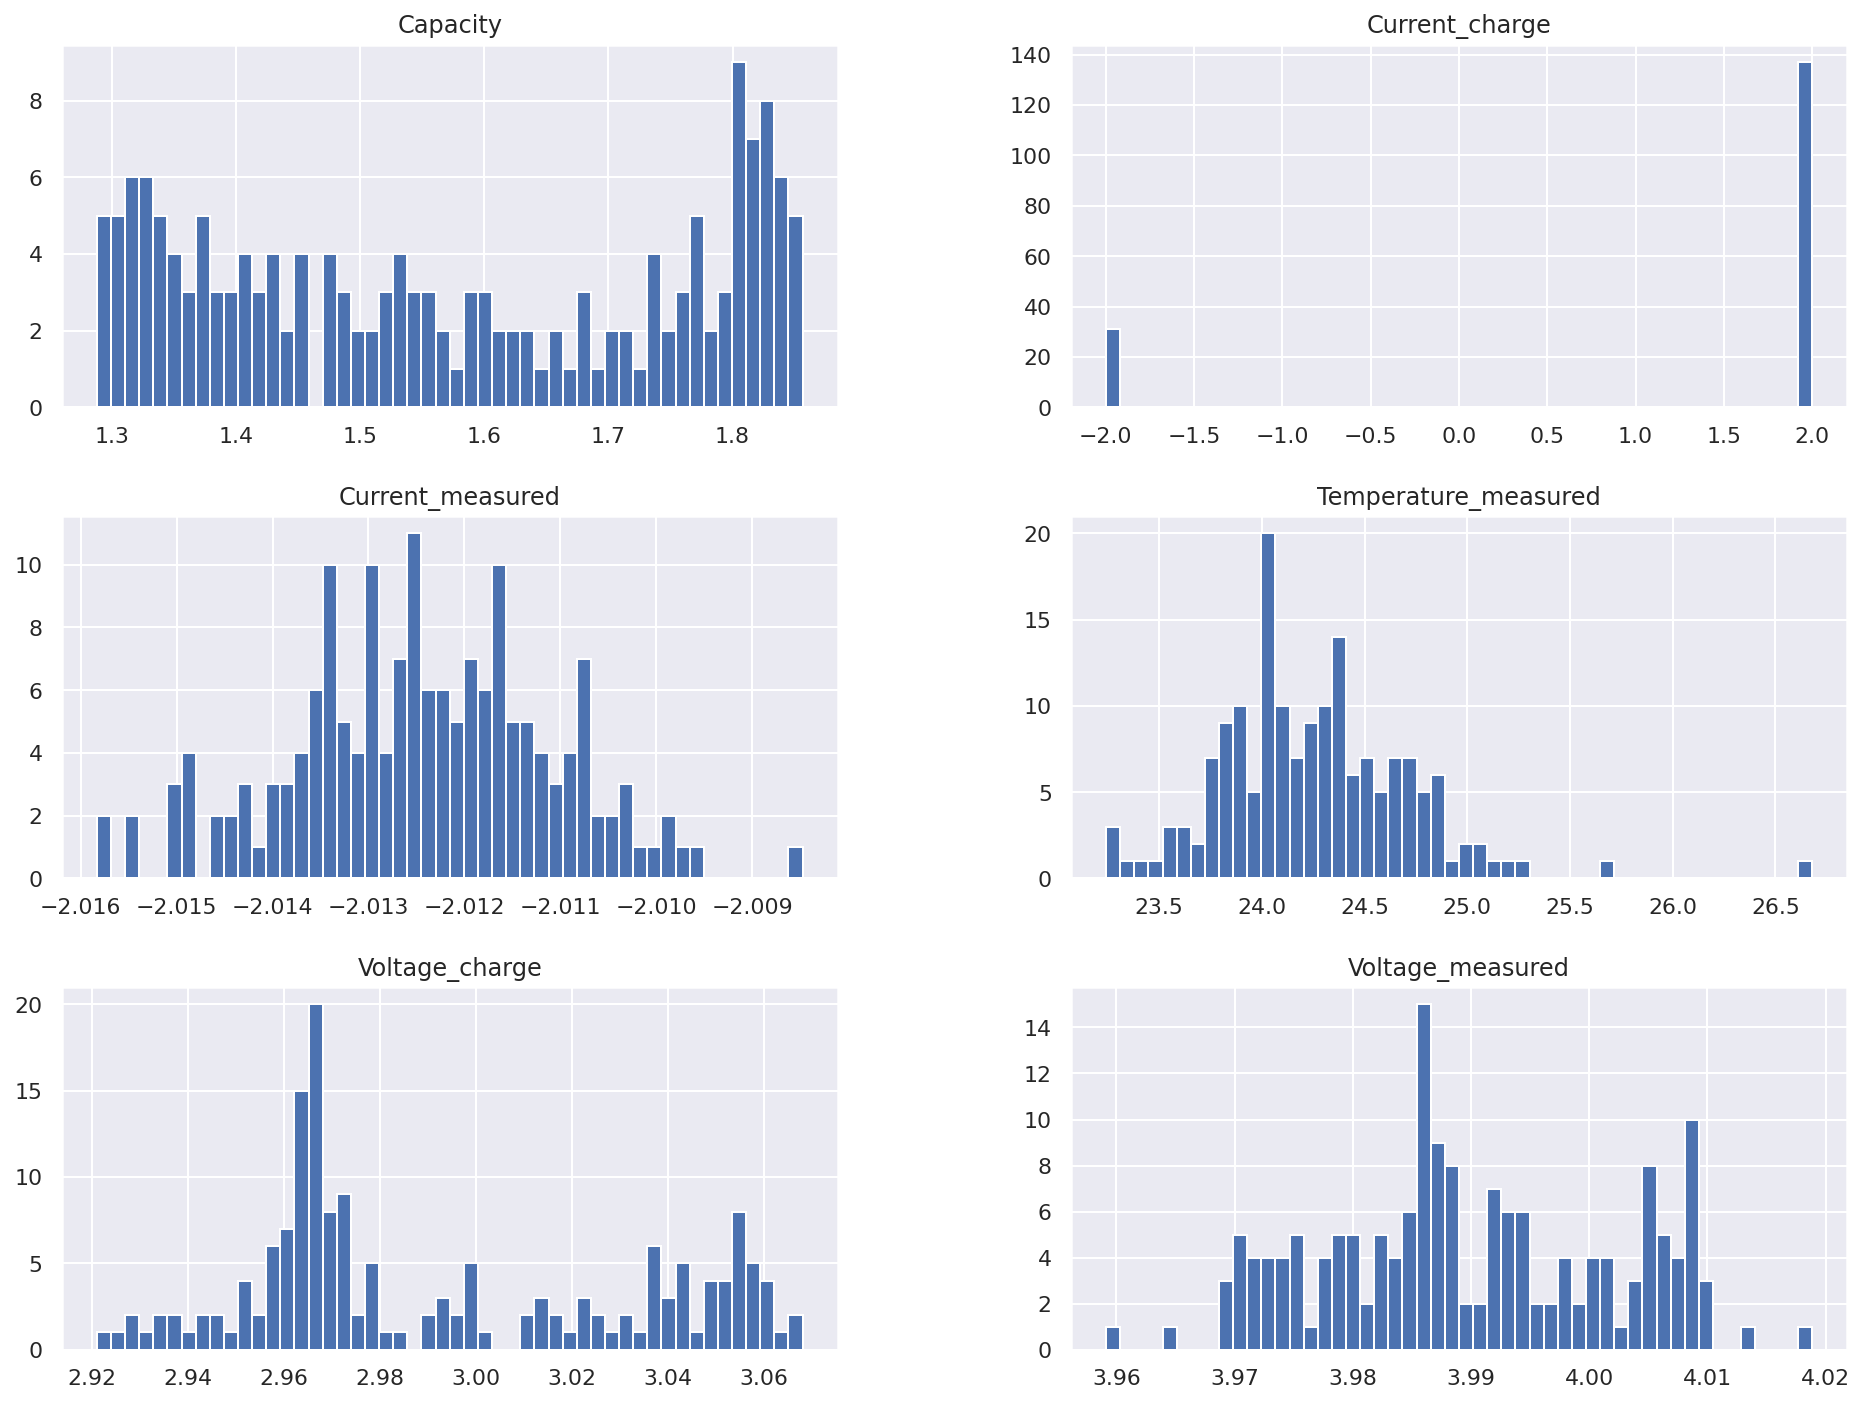

In [17]:
df_battery.hist(bins=50, figsize=(16, 12))
plt.show()

## SOH - Data preprocessing

In [18]:
def prepare_dataset_soh(battery_number):
    ### Split a battery dataset between inputs and outputs"""

    battery_file_name = "B00" + f"{battery_number:02d}"
    df_battery = pd.read_csv(download_path + battery_file_name + ".csv")
    
    # Split dataset between input and target data
    x = df_battery.drop("Capacity", axis=1).to_numpy()
    y = df_battery["Capacity"].to_numpy()

    # Standardize input data
    x = StandardScaler().fit_transform(x)
    
    return (x, y)

## SOH - Training models

In [19]:
def get_model_list_soh():
    knn_model = KNeighborsRegressor(n_neighbors=22)
    lr_model = LinearRegression()
    ann_model = Sequential([
        Dense(6, activation="relu", input_shape=(5,)),
        Dense(1)
    ])
    ann_model.compile(optimizer="adam", loss="mse")

    return {"k-NN": knn_model, "LR": lr_model}

In [20]:
# Return RMSE for a model and a training set
def compute_rmse(model, x, y_true):
    # Compute model predictions for training set
    y_pred = model.predict(x)

    # Compute the error between actual and expected results
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [21]:
def train_models_soh(model_list, battery_number=5):
    x_train, y_train = prepare_dataset_soh(battery_number)

    for model_name, model in model_list.items():
        if isinstance(model, Sequential):
            # Add training params for Keras-based models
            model.fit(x_train, y_train, batch_size=32, epochs=500, verbose=0)
        else:
            model.fit(x_train, y_train)
        rmse = compute_rmse(model, x_train, y_train)
        print(
            f"Training RMSE for {model_name} model on battery #{battery_number} dataset: {rmse:.06f}"
        )

    return model_list

In [22]:
def eval_models_soh(model_list, battery_number):
    x_eval, y_eval = prepare_dataset_soh(battery_number)
    
    for model_name, model in model_list.items():
        rmse = compute_rmse(model, x_eval, y_eval)
        print(
            f"RMSE for {model_name} model on battery #{battery_number} dataset: {rmse:.06f}"
        )

In [23]:
trained_models_soh = train_models_soh(get_model_list_soh())

Training RMSE for k-NN model on battery #5 dataset: 0.043036
Training RMSE for LR model on battery #5 dataset: 0.034292


In [24]:
trained_models_soh["LR"].coef_

array([ 0.10848063,  0.00022361, -0.01163288, -0.08960297,  0.06651371])

In [25]:
eval_models_soh(trained_models_soh, battery_number=6)

RMSE for k-NN model on battery #6 dataset: 0.091969
RMSE for LR model on battery #6 dataset: 0.056985


## SOH - Predictions

In [26]:
def plot_soh(model_list, battery_number):
    x, y_true = prepare_dataset_soh(battery_number)
    
    initial_capacity = y_true[0]
    
    plt.figure()
    
    # Plot actual SOH
    plt.plot(y_true / initial_capacity, label="Actual")
    
    # Plot SOH for each model
    for model_name, model in model_list.items():
        y_pred = model.predict(x)
        plt.plot(y_pred / initial_capacity, label=model_name)
    
    plt.xlabel("Discharge cycles")
    plt.ylabel("SOHc")
    plt.suptitle(f"SOH evolution over time for battery #{battery_number}")
    
    plt.legend()

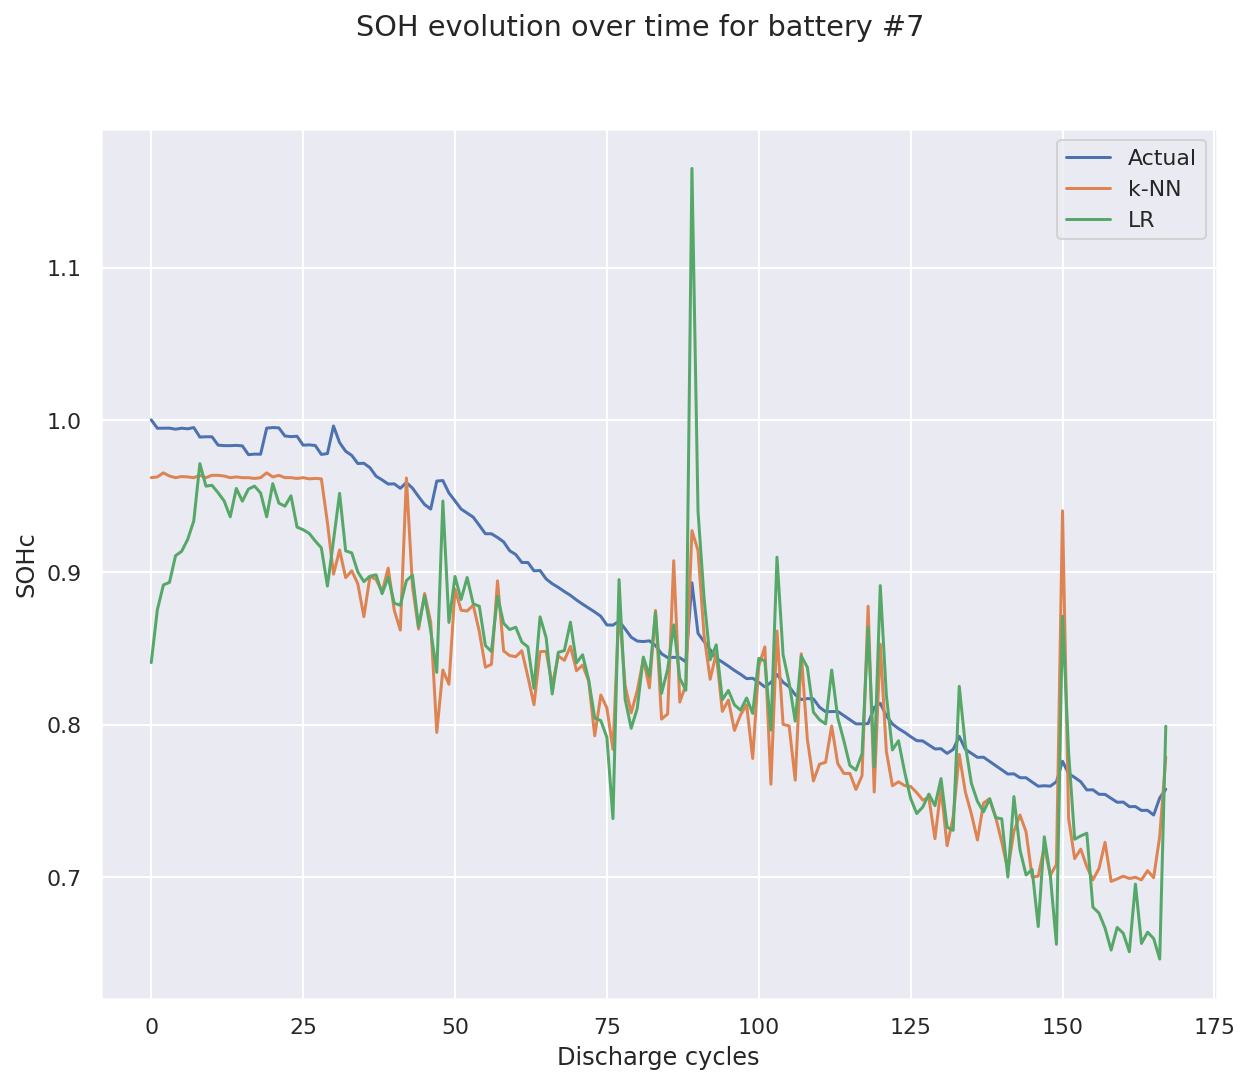

In [27]:
plot_soh(trained_models_soh, battery_number=7)

## RUL - Data preparation

In [28]:
def prepare_dataset_rul_old(battery_number, training_cycle_count):
    ### Split a battery dataset between inputs and outputs"""

    battery_file_name = "B00" + f"{battery_number:02d}"
    df_battery = pd.read_csv(download_path + battery_file_name + ".csv")
    
    x = df_battery[:training_cycle_count].to_numpy()

    initial_capacity = df_battery.loc[0, "Capacity"]

    cycle_number = training_cycle_count
    eol_reached = False
    while (not eol_reached):
        capacity = df_battery.loc[cycle_number, "Capacity"]
        if (capacity / initial_capacity < 0.7 or cycle_number > 163):
            eol_reached = True
        else:
            cycle_number += 1
    ul_cycle_count = cycle_number
    
    y = np.ndarray(training_cycle_count,)
    for i in range(training_cycle_count):
        y[i] = ul_cycle_count - i

    # Standardize input data
    x = StandardScaler().fit_transform(x)
    
    return (x, y)

In [29]:
def train_models_rul_old(model_list, battery_number=5, training_cycle_count=80):
    x_train, y_train = prepare_dataset_rul(battery_number, training_cycle_count)

    for model_name, model in model_list.items():
        if isinstance(model, Sequential):
            # Add training params for Keras-based models
            model.fit(x_train, y_train, batch_size=32, epochs=500, verbose=0)
        else:
            model.fit(x_train, y_train)

        x_pred = np.reshape(x_train[training_cycle_count-1, :], (1, 6))
        model_rul = model.predict(x_pred)
        print(model_rul, y_train[training_cycle_count - 1])
        rul_error = np.abs(model_rul.flatten()[0] - y_train[training_cycle_count - 1])
        #rul_error = rul_error_array.flatten()[0]
        print(
            f"Training error for {model_name} model on battery #{battery_number} dataset: {rul_error:.06f}"
        )

    return model_list

In [30]:
def prepare_dataset_rul(battery_number, training_cycle_count):
    ### Split a battery dataset between inputs and outputs"""

    x, y = prepare_dataset_soh(battery_number)

    x = x[:training_cycle_count]
    y = y[:training_cycle_count]
    
    return (x, y)

In [31]:
x, y = prepare_dataset_rul(5, 40)

## RUL - Training models

In [32]:
def get_model_list_rul():
    knn_model = KNeighborsRegressor(n_neighbors=5)
    lr_model = LinearRegression()
    ann_model = Sequential([
        Dense(6, activation="relu", input_shape=(5,)),
        Dense(1)
    ])
    ann_model.compile(optimizer="rmsprop", loss="mae")

    return {"k-NN": knn_model, "LR": lr_model}

In [33]:
def compute_capacity(model, x):
    x_pred = np.reshape(x, (1, 5))
    y_pred = model.predict(x_pred)
    return y_pred.flatten()[0]

In [34]:
def train_models_rul(model_list, battery_number=5, training_cycle_count=80):
    x_train, y_train = prepare_dataset_soh(battery_number)

    x_train_rul = x_train[:training_cycle_count]
    y_train_rul = y_train[:training_cycle_count]

    initial_capacity = y_train[0]

    for model_name, model in model_list.items():
        if isinstance(model, Sequential):
            # Add training params for Keras-based models
            model.fit(x_train_rul, y_train_rul, batch_size=32, epochs=500, verbose=0)
        else:
            model.fit(x_train_rul, y_train_rul)

        cycle_number = training_cycle_count
        eol_reached = False
        while (not eol_reached):
            capacity = df_battery.loc[cycle_number, "Capacity"]
            if (capacity / initial_capacity < 0.7 or cycle_number > 163):
                eol_reached = True
            else:
                cycle_number += 1
        rul_true = cycle_number - training_cycle_count

        cycle_number = training_cycle_count
        eol_pred_reached = False
        while (not eol_pred_reached):
            capacity = compute_capacity(model, x_train[cycle_number])
            if (capacity / initial_capacity < 0.7 or cycle_number > 163):
                eol_pred_reached = True
            else:
                cycle_number += 1
        rul_pred = cycle_number - training_cycle_count

        print(rul_true, rul_pred)

        rul_error = np.abs(rul_true - rul_pred)
        print(
            f"Training error for {model_name} model on battery #{battery_number} dataset: {rul_error:.06f}"
        )

    return model_list

In [35]:
trained_models_rul = train_models_rul(get_model_list_rul(), training_cycle_count=40)

121 124
Training error for k-NN model on battery #5 dataset: 3.000000
121 124
Training error for LR model on battery #5 dataset: 3.000000


In [36]:
trained_models_rul = train_models_rul(get_model_list_rul(), training_cycle_count=80)

81 84
Training error for k-NN model on battery #5 dataset: 3.000000
81 84
Training error for LR model on battery #5 dataset: 3.000000


In [37]:
trained_models_rul = train_models_rul(get_model_list_rul(), training_cycle_count=120)

41 44
Training error for k-NN model on battery #5 dataset: 3.000000
41 34
Training error for LR model on battery #5 dataset: 7.000000


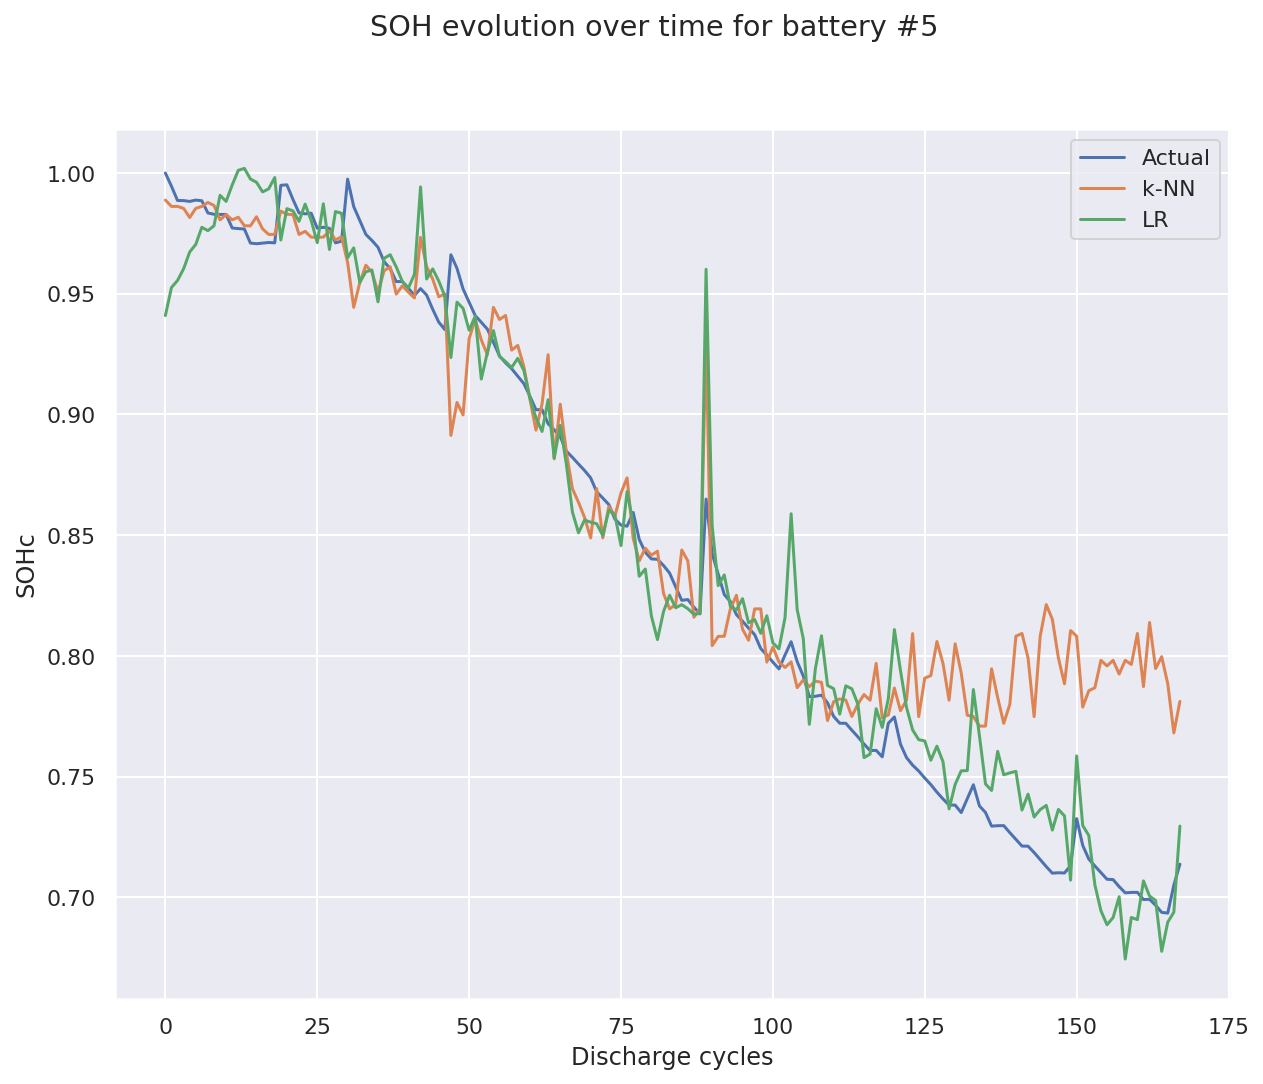

In [38]:
plot_soh(trained_models_rul, 5)

In [39]:
def plot_rul(model, battery_number, training_cycles = [40, 80, 120]):
    x, y_true = prepare_dataset_soh(battery_number)
    
    plt.figure()
    
    # Plot actual capacity
    plt.plot(y_true, label="Actual")
    
    # Plot SOH for each model
    for training_cycle in training_cycles:
        x_train, y_train = prepare_dataset_rul(battery_number, training_cycle)

        y_pred = model.predict(x)
        plt.plot(y_pred / initial_capacity, label=model_name)
    
    plt.xlabel("Discharge cycles")
    plt.ylabel("SOHc")
    plt.suptitle(f"SOH evolution over time for battery #{battery_number}")
    
    plt.legend()